In [1]:
DATE = "2021-06-26"
TASK = "1000bp-1000x-coverage-0.1-error-rate"
DIR = "$(DATE)-$(TASK)"
DIR = mkpath("$(homedir())/$(DIR)")

"/Users/cameronprybol/2021-06-26-1000bp-1000x-coverage-0.1-error-rate"

In [2]:
function plot_kmer_frequency_spectra(counts; log_scaled = true, kwargs...)
    kmer_counts_hist = StatsBase.countmap(c for c in counts)
    xs = collect(keys(kmer_counts_hist))
    ys = collect(values(kmer_counts_hist))
    if log_scaled
        xs = log.(xs)
        ys = log.(ys)
    end
    
    StatsPlots.plot(
        xs,
        ys,
        xlims = (0, maximum(xs) + max(1, ceil(0.1 * maximum(xs)))),
        ylims = (0, maximum(ys) + max(1, ceil(0.1 * maximum(ys)))),
        seriestype = :scatter,
        legend = false,
        xlabel = log_scaled ? "log(observed frequency)" : "observed frequency",
        ylabel = log_scaled ? "log(# of kmers)" : "observed frequency",
        ;kwargs...
    )
end

plot_kmer_frequency_spectra (generic function with 1 method)

In [3]:
pkgs = [
"LightGraphs",
"MetaGraphs",
"BioSequences",
"Random",
"ProgressMeter",
"Revise",
"FASTX",
"StatsBase",
"StatsPlots"
]

import Pkg
Pkg.add(pkgs)
for pkg in pkgs
    eval(Meta.parse("import $(basename(pkg))"))
end

import Mycelia

In [9]:
function visualize_gfa_file(gfa_file)
    run(`/Applications/Bandage.app/Contents/MacOS/Bandage image $(gfa_file) $(gfa_file).svg --depwidth 1 --deppower 1`)
    # --nodewidth <float> Average node width (0.5 to 1000, default: 5)
    # --depwidth <float>  Depth effect on width (0 to 1, default: 0.5)
    # --deppower <float>  Power of depth effect on width (0 to 1, default: 0.5)
    html_path_to_svg = "./" * repeat("../", length(split(pwd(), '/')) - 3)
    html_path_to_svg *= replace("$(gfa_file).svg", "$(homedir())/" => "")
    x = display("text/html", "<img src=$(html_path_to_svg)>")
end

visualize_gfa_file (generic function with 1 method)

In [4]:
# parameters
# set a random seed
seed = Random.seed!(0)
# randomly generate a dna sequence of 100bp
genome = BioSequences.randdnaseq(seed, 1000)
# define error rate
error_rate = 0.1
# generate 100x coverage fastq file
# put accuracy rate into fastq file
coverage = 1000

1000

In [5]:
fastq_file = "$(DIR)/$(DATE)-$(TASK).fastq"
error_free_fastq_file = "$(DIR)/$(DATE)-$(TASK).error-free.fastq"

fastq_io = FASTX.FASTQ.Writer(open(fastq_file, "w"))
error_free_fastq_io = FASTX.FASTQ.Writer(open(error_free_fastq_file, "w"))
for i in 1:coverage
    true_sequence = Mycelia.observe(genome, error_rate=0.0)
    quality_scores = fill(60, length(true_sequence))
    error_free_fastq_record = FASTX.FASTQ.Record("$i", true_sequence, quality_scores)
    write(error_free_fastq_io, error_free_fastq_record)
    
    observed_sequence = Mycelia.observe(genome, error_rate=error_rate)
    q = -10 * log10(error_rate)
    quality_scores = fill(q, length(observed_sequence))
    fastq_record = FASTX.FASTQ.Record("$i", observed_sequence, quality_scores)
    write(fastq_io, fastq_record)
end
close(fastq_io)
close(error_free_fastq_io)

In [20]:
k = 11

11

In [21]:
kmer_type = BioSequences.BigDNAMer{k}

BioSequences.BigDNAMer{11} (alias for BioSequences.BigMer{BioSequences.DNAAlphabet{2}, 11})

In [22]:
kmer_counts = Mycelia.count_canonical_kmers(kmer_type, fastq_file)

OrderedCollections.OrderedDict{BioSequences.BigDNAMer{11}, Int64} with 270568 entries:
  AAAAAAAAATT => 1
  AAAAAAAATAT => 2
  AAAAAAAATCA => 1
  AAAAAAAATGC => 3
  AAAAAAAATGG => 1
  AAAAAAAATTA => 1
  AAAAAAAATTT => 4
  AAAAAAACCGC => 1
  AAAAAAACGCC => 1
  AAAAAAACTAT => 1
  AAAAAAAGCAG => 1
  AAAAAAAGCGC => 4
  AAAAAAAGCGG => 1
  AAAAAAAGGAC => 1
  AAAAAAAGGCC => 1
  AAAAAAAGGGA => 5
  AAAAAAAGGGC => 1
  AAAAAAAGGGT => 1
  AAAAAAAGTTA => 1
  AAAAAAATATC => 1
  AAAAAAATATG => 1
  AAAAAAATATT => 32
  AAAAAAATCAC => 2
  AAAAAAATCCG => 1
  AAAAAAATGAA => 2
  ⋮           => ⋮

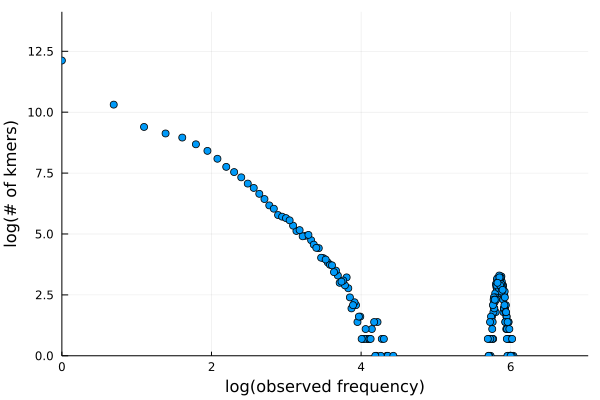

In [23]:
plot_kmer_frequency_spectra(values(kmer_counts))

In [24]:
@time simple_kmer_graph = Mycelia.fastx_to_simple_kmer_graph(kmer_type, fastq_file)

┌ Info: creating graph
└ @ Mycelia /Users/cameronprybol/.julia/dev/Mycelia/src/Mycelia.jl:2958


 16.038840 seconds (52.35 M allocations: 5.289 GiB, 30.91% gc time)


{270568, 655054} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0)

In [ ]:
# gfa_file = fastq_file * ".k-$k.gfa"
# Mycelia.graph_to_gfa(simple_kmer_graph, gfa_file)
# visualize_gfa_file(gfa_file)

In [33]:
2^6

64

In [43]:
solid_vertices = filter(v -> simple_kmer_graph.vprops[v][:weight] >= 64, LightGraphs.vertices(simple_kmer_graph))
polished_simple_kmer_graph, vertex_map = LightGraphs.induced_subgraph(simple_kmer_graph, solid_vertices)

({1008, 2016} directed Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), [130, 157, 484, 539, 783, 1182, 1523, 1814, 1957, 2032  …  267280, 267933, 268348, 268415, 269221, 269694, 269800, 270254, 270425, 270468])

In [48]:
StatsBase.mean(values(kmer_counts))

3.673213388131634

In [ ]:
polished_fastq_file = Mycelia.simple_polish_fastq(simple_kmer_graph, fastq_file, min_depth=)

In [45]:
# @time polished_simple_kmer_graph = Mycelia.fastx_to_simple_kmer_graph(kmer_type, polished_fastq_file)
# gfa_file = polished_fastq_file * ".k-$k.gfa"
gfa_file = fastq_file * ".polished.k-$k.gfa"
Mycelia.graph_to_gfa(polished_simple_kmer_graph, gfa_file)
visualize_gfa_file(gfa_file)

In [41]:
error_free_simple_kmer_graph = Mycelia.fastx_to_simple_kmer_graph(kmer_type, error_free_fastq_file)
# visualize
gfa_file = error_free_fastq_file * ".k-$k.gfa"
Mycelia.graph_to_gfa(error_free_simple_kmer_graph, gfa_file)
visualize_gfa_file(gfa_file)

┌ Info: creating graph
└ @ Mycelia /Users/cameronprybol/.julia/dev/Mycelia/src/Mycelia.jl:2958


In [42]:
Mycelia.kmer_graph_distances(error_free_simple_kmer_graph, polished_simple_kmer_graph)

(kmer_distance = 0.0499040307101728, edge_distance = 0.05358851674641152)

In [ ]:
Mycelia.kmer_graph_distances(error_free_simple_kmer_graph, simple_kmer_graph)